In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import re
import numpy as np

In [2]:
sns.set_style("whitegrid")
sns.set_context("paper")

In [3]:
# colors = {'mr': "#033270",
#           'cs': "#1368AA",
#           'hr': "#4091C9",
#           'cd': "#4AA8CD",
#           'csp': "#BA746B",
#           'cspcd': "#F29479",
#           'mrr': "#F26A4F",
#           'hrmrr': "#EF3C2D",
#           'hrmrrcspcd': "#CB1B16",
#           'hrmrrcspcdc': "#980E11",
#           'hrmrrcspcdcz': "#65010C"
#           }

colors = {'rodents': "#64b5f6",             #mr
          'primates': "#0d47a1",            #hr
          'glires': "#1976d2",              #mrr
          'eurarchontoglires': "#2196f3",   #hrmrr

          'cattle': "#ffe566",              #cs
          'carnivores': "#ffb700",          #cd
          'ungulates': "#ffdd32",           #csp
          'laurasians': "#ffd400",          #cspcd

          'mammals': "#7fb446",             #hrmrrcspcd
          'tetrapods': "#a98467",           #hrmrrcspcdc
          'vertebrates': "#515151"          #hrmrrcspcdcz
          }

div_time = {'mr': 13.10, 'cs': 24.60,'hr': 28.82, 'cd': 55.4, 'csp': 61.8,'cspcd': 76.0,'mrr': 79.0,  'hrmrr': 87.2, 'hrmrrcspcd': 94.0, 'hrmrrcspcdc': 318.9, 'hrmrrcspcdcz': 429.0}

colors_sorted = {i:colors[i] for i in colors.keys()}

In [4]:
def get_code_conversion(code):
    alignment_code_to_species = {'hr':          'human;rhesus',
                                 'mr':          'mouse;rat',
                                 'cd':          'cat;dog',
                                 'cs':          'cow;sheep',
                                 'csp':         'pig;cow;sheep',
                                 'mrr':         'mouse;rabbit;rat',
                                 'cspcd':       'pig;cow;sheep;dog;cat',
                                 'hrmrr':       'human;mouse;rhesus;rabbit;rat',
                                 'hrmrrcspcd':  'human;mouse;rhesus;rabbit;rat;pig;cow;sheep;dog;cat',
                                 'hrmrrcspcdc': 'human;mouse;rhesus;rabbit;rat;pig;cow;sheep;dog;cat;chicken',
                                 'hrmrrcspcdcz':'human;mouse;rhesus;rabbit;rat;pig;cow;sheep;dog;cat;chicken;zfish'}
    return alignment_code_to_species.get(code)

In [5]:
def get_cynteny_df(aln_name,aln_path = '/Users/fabianpa/Desktop/new_sequences/synteny_3/'):

    aln_fname =  os.path.join(aln_path,aln_name+".synteny")
    with open(aln_fname, 'r') as synteny_file:
        synteny=synteny_file.read()
        species = [s.split(".coord")[0].split('/')[-1] for s in synteny.split('\n', 1)[0].split()[1:]]
        found_aln = re.findall(r"Alignment*", synteny,re.MULTILINE)
        n_aln = list(map(lambda x, y: x + str(y), found_aln, range(1,len(found_aln)+1)))
        all_aln = { key : {} for key in n_aln}

        n_keys=list(range(len(synteny.split('Ali')[1].split('\n')[1].split())))
        for i in synteny.split('Ali'):
            aln=None
            for j in i.split('\n'):
                if j.startswith('gnment '):
                    aln = 'Alignment'+j.split()[1]
                    all_aln[aln]={key : [] for key in n_keys}
                elif  aln :
                    [all_aln[aln][idx].append(j.strip().split()[idx]) for idx in range(len(j.strip().split()))]
    return all_aln,species

def read_coord_file(fname):
    with open(fname, 'r') as coord:
        coord_file = coord.readlines()[1:]
        coord_dict = {
            'Gene_name': [i.strip().split()[0] for i in coord_file if len(i.strip().split()) == 5],
            'Chr': [i.strip().split()[1] for i in coord_file if len(i.strip().split()) == 5],
            'Start': [int(i.strip().split()[2]) for i in coord_file if len(i.strip().split()) == 5],
            'End': [int(i.strip().split()[3]) for i in coord_file if len(i.strip().split()) == 5],
            'Strand': [i.strip().split()[4] for i in coord_file if len(i.strip().split()) == 5]}
    coord.close()
    return coord_dict

def get_tad_in_sb(species, aln,sb_coord,sb_specific_aln=None,shuffle=False,coord_path="/Users/fabianpa/Desktop/new_sequences/sb_in_tad/"):
    count_df = []
    coord_df = []
    for common_name in species:
        coord_fname = os.path.join(coord_path, f"{common_name.lower()}_{aln}.tad.sb.bed")
        specie_aln_name = common_name.lower()+"_"+aln
        try:
            sb_tad_coord = pd.read_csv(coord_fname,sep="\t",usecols=[5,6,7,3,4], names=("aln", "strand", "chr", "start", "stop"),header=None)[["chr", "start", "stop", "aln", "strand"]]
            sb_tad_coord["species"] = common_name
            sb_tad_coord["tad_size"] = sb_tad_coord["stop"] - sb_tad_coord["start"]
            if sb_specific_aln :  coord_df.append(sb_tad_coord[sb_tad_coord.aln.isin(sb_specific_aln[specie_aln_name])])
            else: coord_df.append(sb_tad_coord)
            count_list = []
            for i in sb_coord.aln.unique():
                count = len(sb_tad_coord[(sb_tad_coord.aln==i)])
                count_list.append([i,count,common_name])
                
            if sb_specific_aln :
                df = pd.DataFrame(count_list, columns=['aln', 'count',"species"])
                if shuffle:df["count"] = df["count"].sample(frac=1).values
                count_df.append(df[df["aln"].isin(sb_specific_aln[specie_aln_name])])
            else: count_df.append(pd.DataFrame(count_list, columns=['aln', 'count',"species"]))

        except FileNotFoundError as e:
            raise FileNotFoundError(f"File not found: {e.filename}")
    return count_df, coord_df

def get_equal_tad_count_syn_blocks(tad_count,species):

    s1_count = tad_count.loc[(tad_count.species == species[0])]
    s2_count = tad_count.loc[(tad_count.species == species[1])]

    count_diff = s1_count["count"] - s2_count["count"]
    count_diff_df = pd.DataFrame({"aln": s1_count.aln, "count_s1": s1_count["count"],
                                  "count_s2":s2_count["count"], "count_diff": count_diff})
    return count_diff_df.loc[(count_diff_df["count_diff"] == 0) | ((count_diff_df["count_s1"] == 0) |(count_diff_df["count_s2"] == 0)), "aln"].values.tolist()

def get_sb_len(species,aln,path="/Users/fabianpa/Desktop/new_sequences/synteny_3/synteny_bed"):
    sb_dfs = []
    for common_name in species:
        fname = os.path.join(path,common_name+"_"+aln+".bed")
        sb_df = pd.read_table(fname, names=("chr", "start", "stop", "aln", "strand"),header=None)
        sb_df["species"] = common_name
        sb_df["sb_length"]  = sb_df["stop"]- sb_df["start"]
        sb_dfs.append(sb_df)
    return pd.concat(sb_dfs, axis=0)

In [6]:
def find_length_of_longest_list_in_odd_keys(all_aln):
    max_length = 0

    for key, value in all_aln.items():
        if key % 2 != 0:
            cleaned_value = [item for item in value if item != "-"]
            current_length = len(cleaned_value)
            if current_length > max_length:
                max_length = current_length

    return max_length

In [7]:
def get_n_markers(coord, species, aln_range):

    path = coord + species + ".coord"
    coord_df = pd.read_csv(path, skiprows=1, names=("gene", "chr", "start", "stop", "strand"), delim_whitespace=True, header=None).dropna()
    coord_df[["start", "stop"]] = coord_df[["start", "stop"]].apply(pd.to_numeric)

    chr = aln_range[0].split("chr")[1]
    coord_df = coord_df[coord_df.chr == chr]
    start = aln_range[1] + 1
    stop = aln_range[2]
    coord_df = coord_df.loc[(coord_df['start'] >= start) & (coord_df['stop'] <= stop)].sort_values(by=['start'])
    return coord_df

def get_coverage(df, species, genome_size, mode="synteny"):

    if mode == "synteny":
        genome_size_df = pd.read_table(genome_size, names=('species', 'gene_number'), header=None)
        species_genes = genome_size_df.loc[genome_size_df['species'].isin(species)]
        tot_n_markers = dict(zip(
            species_genes['species'].map(lambda x: x),
            species_genes['gene_number']
        ))

        # Create a dictionary to store species markers
        sbfs_markers = {}

        # Collect the markers for each species
        for i in df.columns.levels[0]:
            for j in species:
                species_df = df[i][j].dropna()
                species_code = j.split(".coord")[0]
                species_markers = species_df[species_df != "-"].values.tolist()
                if species_code not in sbfs_markers:
                    sbfs_markers[species_code] = species_markers
                else:
                    sbfs_markers[species_code].extend(species_markers)

        # Count the number of unique markers for each species
        sbfs_n_markers = {key: len(set(values)) for key, values in sbfs_markers.items()}

        # Calculate species synteny coverage
        species_synteny_coverage = {k:  v / tot_n_markers[k] for k, v in sbfs_n_markers.items()}
        return species_synteny_coverage


In [8]:
outer_pbar = tqdm(div_time.keys(),position=0, leave=True)
edit_operations=[]
edit_operations_rdm=[]
nAlignment={}
all_aln_len={}
mean_gap={}
mean_cov = {}
genome_size = "../../data/latest_assembly/coord_file/p_coding_genes.tsv"

for aln in outer_pbar:
    aln_len = []
    outer_pbar.set_description(f'Processing Alignments - {aln}')
    aln_path = "/Users/fabianpa/Desktop/new_sequences/synteny_3/"
    coord_path = "/Users/fabianpa/Desktop/new_sequences/coord"
    
    all_aln,species = get_cynteny_df(aln)

    for i in list(all_aln.keys())[:]:
        length_of_longest_list = find_length_of_longest_list_in_odd_keys(all_aln[i])
        aln_len.append(length_of_longest_list)

    # aln_len = [len(all_aln[i][1]) for i in all_aln.keys()]
    mean_gap[aln]=(np.mean([all_aln[i][1].count('-')/len(all_aln[i][1]) for i in all_aln.keys()])*100)
    all_aln_len[aln]=aln_len
    reform = {(outerKey, innerKey): values for outerKey, innerDict in all_aln.items() for innerKey, values in innerDict.items()}
    df = pd.DataFrame.from_dict(reform, orient='index').transpose()
    df.columns = pd.MultiIndex.from_tuples(df.columns)
    column_n = list(range(1,len(df['Alignment1'].columns),2))
    columns_name = {column_n[i] :species[i] for i in range(len(column_n))}
    df.rename(columns =columns_name, inplace = True)
    nAlignment[aln] = len(df.columns.levels[0])

    cov = get_coverage(df, species, genome_size)
    mean_cov[aln] = round(sum(list(cov.values())) / len(cov), 2)
    species = get_code_conversion(aln).split(';')
    sb_coord = get_sb_len(species,aln)
    species_coords = {f: read_coord_file(os.path.join(coord_path, f + ".coord")) for f in species}

Processing Alignments - hrmrrcspcdcz: 100%|██████████| 11/11 [00:06<00:00,  1.58it/s]


In [9]:
species_mapping = {'mr':'rodents',
                   'hr':'primates',
                   'mrr':'glires',
                   'hrmrr':'eurarchontoglires',

                   'cs':'cattle',
                   'cd':'carnivores',
                   'csp':'ungulates',
                   'cspcd':'laurasians',

                   'hrmrrcspcd':'mammals',
                   'hrmrrcspcdc':'tetrapods',
                   'hrmrrcspcdcz':"vertebrates"}

In [10]:
def get_n_aln(path):
    nAlignment={}
    for file in os.listdir(path):
        if file != "synteny_bedpe" and file!="synteny_bed":
            fname = os.path.basename(file).split('.')[0]
            all_aln,species = get_cynteny_df(path+fname)
            reform = {(outerKey, innerKey): values for outerKey, innerDict in all_aln.items() for innerKey, values in innerDict.items()}
            df = pd.DataFrame.from_dict(reform, orient='index').transpose()
            df.columns = pd.MultiIndex.from_tuples(df.columns)
            nAlignment[fname] = len(df.columns.levels[0])
    return nAlignment

path="/Users/fabianpa/Desktop/new_sequences/synteny_3/"
nAlignment = get_n_aln(path)
sb_number = {i:nAlignment[i] for i in species_mapping.keys()}
sb_number_df = pd.DataFrame.from_dict(sb_number, orient='index').reset_index()
sb_number_df.rename(columns={0: "count",'index':"species"},inplace=True)
sb_number_df["species"] = sb_number_df["species"].replace(species_mapping)
sb_number_df["color"] = sb_number_df["species"].map(colors)
sb_number_df

,species,count,color
0,rodents,122,#64b5f6
1,primates,100,#0d47a1
2,glires,372,#1976d2
3,eurarchontoglires,422,#2196f3
4,cattle,100,#ffe566
5,carnivores,207,#ffb700
6,ungulates,290,#ffdd32
7,laurasians,451,#ffd400
8,mammals,528,#7fb446
9,tetrapods,651,#a98467


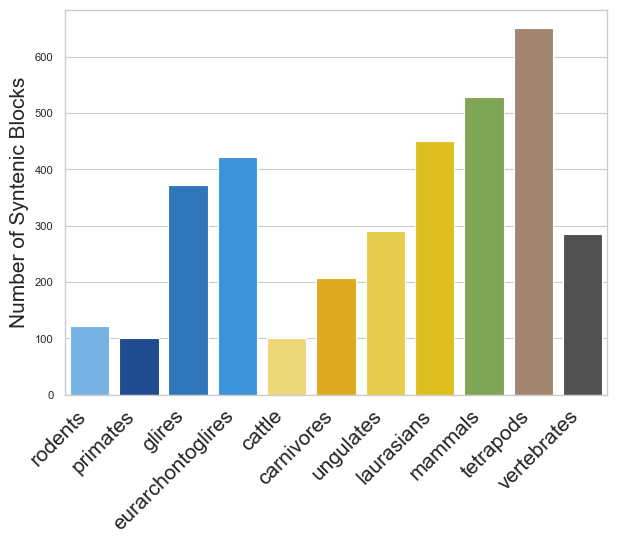

In [29]:
plt.figure(figsize=(7, 5))
sns.barplot(data=sb_number_df, x='species', y='count',hue= "species", palette=list(sb_number_df["color"]),legend=False)
plt.xticks(rotation=45,fontsize=15,ha="right")
plt.yticks(fontsize=8)
plt.xlabel("")
plt.ylabel("Number of Syntenic Blocks",fontsize=15)

plt.savefig("../images/figure 1/sb_count.2.svg", bbox_inches='tight')
plt.show()

In [12]:
# gap_perc = {i:mean_gap[i] for i in div_time}
# gap_perc_df = pd.DataFrame.from_dict(gap_perc, orient='index').reset_index()
# gap_perc_df.rename(columns={0: "count",'index':"species"},inplace=True)
# plt.figure(figsize=(15, 11))
# sns.barplot(data=gap_perc_df, x='species', y='count',hue="species", palette=list(colors_sorted.values()),legend=True)
# plt.xticks(rotation=90,fontsize=18)
# plt.yticks(fontsize=18)
# plt.xlabel("")
# plt.ylabel("Avg % Gap per SB Collection",fontsize=18)
# handles, labels = plt.gca().get_legend_handles_labels()
# labels =[f"{label}:{alignment_code_to_species_legend[label]}" for label in labels]
#
# plt.legend(handles,labels, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False,fontsize=18)
# # plt.savefig("../images/supplementary/sb_gap.png", bbox_inches='tight')
# plt.show()

In [13]:
sb_len = {i:all_aln_len[i] for i in div_time}
sb_len_df = pd.DataFrame.from_dict(sb_len,orient="index")
nplots = len(sb_len_df.columns)
sb_len_df= sb_len_df.reset_index() 
df_melted = sb_len_df.melt(id_vars=["index"], var_name="variable", value_name="value")
sb_len_df["max"]=sb_len_df.loc[:, sb_len_df.columns != "index"].max(axis=1)
sb_len_df["min"]=sb_len_df.loc[:, sb_len_df.columns != "index"].min(axis=1)
sb_len_df['iqr'] = sb_len_df.loc[:, sb_len_df.columns != "index"].apply(lambda x: np.percentile(x.dropna(), 75) - np.percentile(x.dropna(), 25), axis=1)
sb_len_df["mean"] = round(sb_len_df.loc[:, sb_len_df.columns != "index"].mean(axis=1,skipna=True),2)
sb_len_df["median"] = round(sb_len_df.loc[:, sb_len_df.columns != "index"].median(axis=1,skipna=True),2)
sb_len_df["std"] = round(sb_len_df.loc[:, sb_len_df.columns != "index"].std(axis=1, skipna=True),2)
sb_len_df.rename(columns={'index':"species"},inplace=True)
sb_len_df["species"] = sb_len_df["species"].replace(species_mapping)
stat = sb_len_df[["species","min","max","iqr","mean","median","std"]]
# stat = sb_len_df[["species","min","max","iqr","median","std"]]
stat

,species,min,max,iqr,mean,median,std
0,rodents,2.0,1767.0,136.50,188.19,34.5,367.83
1,cattle,3.0,1271.0,334.00,227.12,17.0,358.42
2,primates,2.0,1517.0,275.00,214.82,50.0,339.72
3,carnivores,2.0,1021.0,129.00,103.40,13.0,175.74
4,ungulates,2.0,718.0,66.25,70.32,20.0,122.36
5,laurasians,2.0,567.0,41.00,40.30,13.0,70.55
6,glires,2.0,949.0,39.75,41.05,15.0,87.29
7,eurarchontoglires,2.0,505.0,31.25,31.93,14.0,53.47
8,mammals,2.0,245.0,17.00,19.13,8.0,29.24
9,tetrapods,2.0,125.0,8.00,9.27,5.0,11.37


In [14]:
mean_cov_df = pd.DataFrame.from_dict(mean_cov, orient='index').reset_index()
mean_cov_df.rename(columns={0: "coverage"}, inplace=True)
mean_cov_df.reset_index(inplace=True)
mean_cov_df.rename(columns={"index": "species"}, inplace=True)
mean_cov_df["species"] = mean_cov_df["species"].replace(species_mapping)
stat = stat.merge(mean_cov_df[['species', 'coverage']], on='species')
stat.to_csv("../images/supplementary/syn_blocks_stat.csv", index=False)
stat

,species,min,max,iqr,mean,median,std,coverage
0,rodents,2.0,1767.0,136.50,188.19,34.5,367.83,0.95
1,cattle,3.0,1271.0,334.00,227.12,17.0,358.42,0.98
2,primates,2.0,1517.0,275.00,214.82,50.0,339.72,0.97
3,carnivores,2.0,1021.0,129.00,103.40,13.0,175.74,0.97
4,ungulates,2.0,718.0,66.25,70.32,20.0,122.36,0.91
5,laurasians,2.0,567.0,41.00,40.30,13.0,70.55,0.79
6,glires,2.0,949.0,39.75,41.05,15.0,87.29,0.62
7,eurarchontoglires,2.0,505.0,31.25,31.93,14.0,53.47,0.57
8,mammals,2.0,245.0,17.00,19.13,8.0,29.24,0.43
9,tetrapods,2.0,125.0,8.00,9.27,5.0,11.37,0.26


In [15]:
# sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
#
# g = sns.FacetGrid(df_melted, row='index', hue='index', aspect=15, height=0.95, palette=list(colors_sorted.values()),sharex=False,sharey=False)
# g.map(sns.kdeplot, 'value',bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
# # Add horizontal lines
# g.map(plt.axhline, y=0, lw=2, clip_on=False)
# g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
# # Add text labels
# for i, ax in enumerate(g.axes.flat):
#     index_name = df_melted['index'].unique()[i]
#     subset = df_melted[df_melted['index'] == index_name]['value']
#     mean_value = round(subset.mean())
#     ax.set_xticks(ax.get_xticks()[-1:])
#     if df_melted['index'][i] in ['mr']: ax.text(1851, 0.0001, df_melted['index'][i], fontweight='bold', fontsize=15, color=ax.lines[-1].get_color(),horizontalalignment='right')
#     elif df_melted['index'][i] in ['hr']: ax.text(1643, 0.0001, df_melted['index'][i], fontweight='bold', fontsize=15, color=ax.lines[-1].get_color(),horizontalalignment='right')
#     elif df_melted['index'][i] == 'cs': ax.text(1330, 0.00009, df_melted['index'][i], fontweight='bold', fontsize=15, color=ax.lines[-1].get_color(),horizontalalignment='right')
#     elif df_melted['index'][i] =='cd': ax.text(1400, 0.0002, df_melted['index'][i], fontweight='bold', fontsize=15, color=ax.lines[-1].get_color(),horizontalalignment='right')
#     elif df_melted['index'][i] =='csp': ax.text(1000, 0.0002, df_melted['index'][i], fontweight='bold', fontsize=15, color=ax.lines[-1].get_color(),horizontalalignment='right')
#     elif df_melted['index'][i] in ['cspcd','hrmrr']: ax.text(800, 0.0002, df_melted['index'][i], fontweight='bold', fontsize=15, color=ax.lines[-1].get_color(),horizontalalignment='right')
#     elif df_melted['index'][i] =='mrr': ax.text(1200, 0.0002, df_melted['index'][i], fontweight='bold', fontsize=15, color=ax.lines[-1].get_color(),horizontalalignment='right')
#     elif df_melted['index'][i] =='hrmrrcspcd': ax.text(350, 0.0002, df_melted['index'][i], fontweight='bold', fontsize=15, color=ax.lines[-1].get_color(),horizontalalignment='right')
#     elif df_melted['index'][i] == 'hrmrrcspcdc': ax.text(200, 0.0002, df_melted['index'][i], fontweight='bold', fontsize=15, color=ax.lines[-1].get_color(),horizontalalignment='right')
#     elif df_melted['index'][i] == 'hrmrrcspcdcz': ax.text(22.5, 0.0002, df_melted['index'][i], fontweight='bold', fontsize=15, color=ax.lines[-1].get_color(),horizontalalignment='right')
#
# # Adjust subplot layout
# g.fig.subplots_adjust(hspace=-0.3)
#
# # Remove titles, yticks, and spines
# g.set_titles("")
# g.set(yticks=[])
# g.set(ylabel="")
# g.despine(bottom=True, left=True)
#
# # Set x-axis labels and title
# plt.xlabel('Gene Count within Syntenic Block', fontweight='bold', fontsize=15)
# g.fig.suptitle('Gene distribution within Syntenic Blocks', ha='right', fontsize=20, fontweight=20,horizontalalignment='left')
# # plt.savefig("../images/sb_len_distr.png",bbox_inches='tight')
# plt.show()

In [16]:
# nplots = len(sb_len_df.columns)
# ncols = 4
# nrows = 3
# fig, axs = plt.subplots(nrows, ncols, figsize=(15, 20))
# for i, ax in enumerate(axs.flatten()):
#     if i<11:
#         aln= sb_len_df.columns.values[i]
#         color= (colors)[aln]
#         sns.violinplot(data=sb_len_df[aln].dropna(),ax=ax,color=color,inner = "quart",fill=False,linewidth=1.7)
#         # sns.violinplot(data=sb_len_df[aln].dropna(),ax=ax,color=color,inner = "point",inner_kws={"color": "white","edgecolor": "white"})
#         ax.set_xticklabels("")
#         ax.yaxis.set_tick_params(labelsize=18)
#         ax.set_ylabel("")
#         ax.set_title(aln,fontsize=18)
#     else: fig.delaxes(ax)
#
# fig.supylabel('Gene Count within Syntenic Blocks',fontsize=18)
# plt.tight_layout()
# # plt.savefig("images/sb_len.png",bbox_inches='tight')
# plt.show()

In [17]:
# lenght=sb_len_df[["hr","mr","cd","cs"]].dropna().values.tolist()
# # lenght=sum([sb_len_df[i].dropna().values.tolist() for i in sb_len_df.columns], [])
# long_threshold = np.percentile(lenght, 67)
# short_threshold = np.percentile(lenght, 33)
# long_threshold,short_threshold

In [18]:
bed_path="/Users/fabianpa/Desktop/new_sequences/synteny_3/synteny_bed"
# div_time = {'hr': 28.82} 
aln_length = []
for aln in div_time.keys():
    species = get_code_conversion(aln).split(';')
    for i in species:
        bed_f_name = os.path.join(bed_path,i+"_"+aln+".bed")
        df = pd.read_table(bed_f_name,header=None,index_col=False,names=["chr","start","end","aln","strand"])
        df['length'] = (df.end - df.start)/1000
        species_list =[i]*(len(df['length'].to_list()))
        aln_length.append([aln,df['length'].to_list(),i])

lenght_df = pd.DataFrame(aln_length)
lenght_df = lenght_df.explode(1)
lenght_df.columns = ['Alignment', "sb_length", 'Species']
avg_diff = lenght_df.groupby(['Alignment', 'Species'])['sb_length'].median().reset_index()
mean_lengths = avg_diff.groupby('Alignment')['sb_length'].median().reset_index()
mean_lengths.set_index('Alignment',inplace=True)
mean_lengths=mean_lengths.reindex(div_time.keys())
mean_lengths["sb_length"]

Alignment
mr              3251.92775
cs                734.4475
hr                4552.167
cd                 979.331
csp                1995.85
cspcd              957.486
mrr               1394.906
hrmrr             1120.829
hrmrrcspcd         565.415
hrmrrcspcdc        307.958
hrmrrcspcdcz      175.5735
Name: sb_length, dtype: object

In [19]:
# fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
# fig.subplots_adjust(wspace=0.06)  # adjust space between axes
#
# # plot the same data on both axes
# sns.scatterplot(x=div_time.values(), y=mean_lengths["sb_length"],legend=False,ax=ax1,hue=div_time.keys(),palette=list(colors_sorted.values()))
# sns.scatterplot(x=div_time.values(), y=mean_lengths["sb_length"],ax=ax2,hue=div_time.keys(),palette=list(colors_sorted.values()) )
#
# # zoom-in / limit the view to different portions of the data
# ax1.set_xlim(0, 110) # most of the data
# ax2.set_xlim(290, 450)   # outliers only
#
# # hide the spines between ax and ax2
# ax1.spines.right.set_visible(False)
# ax1.spines.top.set_visible(False)
# ax2.spines.left.set_visible(False)
# ax2.spines.right.set_visible(False)
# ax2.spines.top.set_visible(False)
#
# # Now, let's turn towards the cut-out slanted lines.
# d = .9  # proportion of vertical to horizontal extent of the slanted line
# kwargs = dict(marker=[(-1, -d), (1, d)], markersize=8,
#               linestyle="none", color='k', mec='k', mew=1, clip_on=False)
# ax1.plot([1, 1], [0, 0], transform=ax1.transAxes, **kwargs)
# ax2.plot([0, 0], [0, 0], transform=ax2.transAxes, **kwargs)
#
# ax1.set_xlabel("                                                            MYA (Million Years Ago)")
# ax1.set_ylabel("number of SB")
# ax2.set(xlabel="", ylabel="")
#
# plt.tight_layout()
# plt.legend(bbox_to_anchor=(-1.2, -0.15), loc='upper left', borderaxespad=0,ncol=3)
# plt.show()
# # plt.savefig("../../data/latest_assembly/paper_figure/sb_lenght.jpeg", bbox_inches='tight')

In [20]:
# # Plotting a categorical scatter plot (strip plot)
# plt.figure(figsize=(20, 10))
# # sns.barplot(x='Alignment', y='sb_length', hue='Species', data=lenght_df)
# sns.stripplot(x='Alignment', y='sb_length', hue='Species', data=lenght_df,alpha=.5)
# plt.ylabel('SB Length')
# # plt.title('Comparison of Differences in HR and MRR Alignments')
# plt.legend(title='Species')
# # Add mean values as text on the x-axis
#
# for idx, row in mean_lengths.iterrows():
#     plt.text(idx, -30000, f"Mean:\n {row['sb_length']:.2f}", ha='center',fontsize=17)
# plt.xlabel('Alignment')
# # Add mean points to the plot using sns.scatterplot() to avoid connecting points
# # sns.pointplot(x='Alignment', y='sb_length', data=mean_lengths, color='black', markers='o',linestyles='--',errwidth=2, scale=1)
#
# # Show the plot
# plt.tight_layout()

In [21]:
# def get_n_markers(coord, species, aln_range):
#
#     path = coord + species + ".coord"
#     coord_df = pd.read_csv(path, skiprows=1, names=("gene", "chr", "start", "stop", "strand"), delim_whitespace=True, header=None).dropna()
#     coord_df[["start", "stop"]] = coord_df[["start", "stop"]].apply(pd.to_numeric)
#
#     chr = aln_range[0].split("chr")[1]
#     coord_df = coord_df[coord_df.chr == chr]
#     start = aln_range[1] + 1
#     stop = aln_range[2]
#     coord_df = coord_df.loc[(coord_df['start'] >= start) & (coord_df['stop'] <= stop)].sort_values(by=['start'])
#     return coord_df
#
# def get_coverage(df, species, genome_size, coord="../data/latest_assembly/coord_file/", aln="hr", mode="synteny"):
#     """
#     Calculate the coverage of species in terms of synteny markers.
#
#     The function calculates the coverage of species based on the number of unique synteny markers present in a DataFrame.
#
#     Parameters
#     ----------
#     df : pandas.DataFrame
#         DataFrame containing synteny marker information.
#     species: list of species codes.
#     genome_size : str
#         Path to the file containing genome size information.
#     coord : str, optional
#         Path to the coordination file. Default is "../data/latest_assembly/coord_file/".
#     aln : str, optional
#         Alignment identifier. Default is "hr".
#     mode : str, optional
#         Mode of operation. Default is "synteny".
#
#     Returns
#     -------
#     dict
#         Dictionary containing the synteny coverage for each species.
#
#     """
#     if mode == "synteny":
#         # Read genome size information
#         genome_size_df = pd.read_table(genome_size, names=('species', 'gene_number'), header=None)
#         # Filter genome size information for specified species
#         species_genes = genome_size_df.loc[genome_size_df['species'].isin(species)]
#         # Create a dictionary mapping species to total number of markers
#         tot_n_markers = dict(zip(
#             species_genes['species'].map(lambda x: x),
#             species_genes['gene_number']
#         ))
#
#         # Create a dictionary to store species markers
#         sbfs_markers = {}
#
#         # Collect the markers for each species
#         for i in df.columns.levels[0]:
#             for j in species:
#                 species_df = df[i][j].dropna()
#                 species_code = j.split(".coord")[0]
#                 species_markers = species_df[species_df != "-"].values.tolist()
#                 if species_code not in sbfs_markers:
#                     sbfs_markers[species_code] = species_markers
#                 else:
#                     sbfs_markers[species_code].extend(species_markers)
#
#         # Count the number of unique markers for each species
#         sbfs_n_markers = {key: len(set(values)) for key, values in sbfs_markers.items()}
#
#         # Calculate species synteny coverage
#         species_synteny_coverage = {k:  v / tot_n_markers[k] for k, v in sbfs_n_markers.items()}
#         return species_synteny_coverage
#
#
# #     elif mode == "marker":
# #         species_synteny_coverage= {}
# #         for i in species:
# #             path="../data/latest_assembly/synteny_bed/sb_per_aln/"
# #             species_code = get_code_conversion(i.split(".coord")[0],"common_name").lower()
# #             filename = path+species_code+"_"+aln+'.bed'
# #             aln_boundary = pd.read_table(filename,names=("chr","start","stop","aln_n","strand"), header=None)
# #             for x,y,z,n in zip(aln_boundary.chr,aln_boundary.start,aln_boundary.stop,aln_boundary.aln_n):
# #                 coord_df = get_n_markers(coord,i.split(".coord")[0],(x,y,z))
# #                 tot_n_markers = len(coord_df)
# #                 species_df = df[n][i].dropna()
# #                 sbfs_n_markers = len(species_df[species_df!="-"])
# #                 if i in species_synteny_coverage: species_synteny_coverage[i].append(sbfs_n_markers/tot_n_markers)
# #                 else: species_synteny_coverage[i]=[sbfs_n_markers/tot_n_markers]
# #         return species_synteny_coverage
# #         # return species_marker_coverage,aln_boundary